In [2]:
#readFeats
import numpy as np
import pandas as pd
import sklearn
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
import os
from sklearn.utils import shuffle
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import hyperopt
from hyperopt import  hp, fmin, tpe, STATUS_OK, Trials
import time
#import 
import warnings
warnings.simplefilter('ignore')


/home/xuhuang/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
inj = pd.read_csv("../Data/Kplr_feat_files_10000.csv", index_col=0)
inv = pd.read_csv("../Data/Inverted_feat_files_fixed_detrended.csv", index_col=0)#[:9000]
#inj_periods = np.loadtxt("../../../Training/simulation/injection/injection.txt", dtype= str, delimiter=",")[:10000, 3].astype("float64")

inj_periods = np.loadtxt("../Data/Kplr_inj_periods_10000.txt")[:,-1]
inj_SNR = np.loadtxt("../Data/SNR_feats_kplr_inj_10000.txt")[:,-1]#[:10000]
inj_tol = np.loadtxt("../Data/Kplr_tol.txt")[:, -1]

koi = pd.read_csv("../Data/KOI_feat_files_3080_labelled_try4.csv", index_col =0)
#del koi["star_id"]
#del koi["segment"]
koi_tol = np.loadtxt("../Data/period_harmonics_3080_koi_signals_tol_5x5_ordered_multiplanet.txt")
koi_SNR = np.loadtxt("../Data/SNR_feats_KOIS_3080_fixed_multiplanet.txt")
koi_periods = np.loadtxt("../Data/koi_periods_multiplanet.txt")

#non pimary koi
non_koi = pd.read_csv("../Data/KOI_non_prim_feat_files_20000_new_detrending.csv", index_col=0)[4000:5000]
test_non_kois = pd.read_csv("../Data/KOI_non_prim_feat_files_20000_new_detrending.csv", index_col=0)[5000:15000]

In [11]:
#make cuts to injected and koi samples to determine what should be labelled true
ped_constraint = 3 # transit cut, this ensures there will be atleast three transits in each 26 days segment
SNR_cut =6 # SNR threshold
inj_enough_transits = ((26./inj_periods) > ped_constraint).astype(int)
tolerance_cut = 0.002

#This is to ensure that aleast of the integers used to minimize period error function is 1 (means it 
#detected the correct signal), or that the ratio of the two can be reduced to 1 to 1 
#(in case the model determined the solution to be something like 2:2, which is equivalent to 1:1)
inj_low_tol = (inj_low_tol<0.02).astype(int)# ((inj_tol[:,0]==1)+(inj_tol[: ,1]==1) + (inj_tol[:,0] == inj_tol[:,1])).astype(int)

#print "Tolerance Cut", len(np.where(inj_low_tol==1)[0])
print "SNR Cut", len(np.where(inj_SNR>SNR_cut)[0])
inj_true_trans = ((inj_SNR>=SNR_cut)*(inj_low_tol==1)*(inj_enough_transits)).astype(int)
print "Retained Transits", len(np.where(inj_true_trans==1)[0])


#koi_cuts
koi_enough_trans = (26/koi_periods >= ped_constraint).astype(int)
koi_low_tol = ((koi_tol[:,0]==1)+(koi_tol[: ,1]==1) + (koi_tol[:,0] == koi_tol[:,1])).astype(int)
koi_enough_sig = (koi_SNR[:,2]>SNR_cut).astype(int)
#this is done because this koi happens to have two planets with roughly eqivalent signals
#thus the bls detects both periods, and this ensures that it is not discarded in the error cuts
indices = np.where(koi_SNR[:,0] == 2989404)[0]
print indices
koi_low_tol[indices] = 1  

koi_true_trans = (koi_enough_trans* koi_low_tol * koi_enough_sig).astype(int)
print "Retained Transits", len(np.where(koi_true_trans==1)[0]), "from", koi.shape[0]


#append Y values
inj["Y"] = inj_true_trans
inv["Y"] = np.zeros(inv.shape[0])
non_koi["Y"] = np.zeros(non_koi.shape[0])

object_labels = np.hstack([np.ones(inj.shape[0]),np.zeros(inv.shape[0])+2,  np.zeros(non_koi.shape[0])+4])
total_signals = pd.concat([inj, inv,  non_koi], axis = 0)

# 1 inj , 2 inv, 3 koi, 4 non kois
#these are object labels given to track the objects later through shuffling and train test splitting
drop_column =  ["BLS_Npointsaftertransit_1_0", "BLS_Npointsintransit_1_0", "BLS_Npointsbeforetransit_1_0",
                "BLS_OOTmag_1_0", "BLS_Tc_1_0", "BLS_Period_1_0"]
total_signals = total_signals.drop(drop_column, axis = 1)
test_non_kois = test_non_kois.drop(drop_column, axis=1)
koi = koi.drop(drop_column, axis = 1)
labels = total_signals["Y"]
del total_signals["Y"]
total_signals.head(1)

SNR Cut 9363
Retained Transits 666
[913 914 915 916 917 918 919 920 921 922 923 924]
Retained Transits 834 from 3080


,BLS_Depth_1_0,BLS_Ntransits_1_0,BLS_Qingress_1_0,BLS_Qtran_1_0,BLS_Rednoise_1_0,BLS_SDE_1_0,BLS_SN_1_0,BLS_SR_1_0,BLS_SignaltoPinknoise_1_0,BLS_Whitenoise_1_0,...,modshiftval1_dv,modshiftval2_dv,modshiftval3_dv,modshiftval4_dv,modshiftval5_dv,modshiftval6_dv,red_noise,segment,star_id,white_noise
0,0.06869,3.0,0.38562,0.01967,0.00174,8.87834,10.04489,0.00502,54.05323,0.0033,...,-3.306894,-2.986028,-2.956016,-11.366729,-13.045968,-13.015955,0.003962,0.0,1026032.0,0.003174


In [12]:
shuffleX, shuffleY , shuffle_labels= shuffle(total_signals, labels, object_labels, random_state =0)
shuffleX = shuffleX.reset_index(drop = True)
shuffleY = shuffleY.reset_index(drop = True)

print shuffleX.shape, shuffleY.shape 
trainX, testX, trainY, testY, train_label, test_label = train_test_split(shuffleX, shuffleY, shuffle_labels, stratify =shuffle_labels, test_size = 0.20,random_state = 0 )

print "Strong Transits in training" , len(np.where([(trainY==1) & (train_label==1)])[0]) 
print "Weak Transits in training" , len(np.where([(trainY==0) & (train_label==1)])[0]) 
print "Inverted Signals in training" , len(np.where([(trainY==0) & (train_label==2)])[0]) 
print "Non kois in Training", len(np.where([(trainY==0) & (train_label==4)])[0]) ,"\n"
print "Strong Transits in testing" , len(np.where([(testY==1) & (test_label==1)])[0]) 
print "Weak Signals in testing" , len(np.where([(testY==0) & (test_label==1)])[0]) 
print "Inverted Signals in testing" , len(np.where([(testY==0) & (test_label==2)])[0]) 
print "Non kois in Testing", len(np.where([(testY==0) & (test_label==4)])[0]) 

(26000, 31) (26000,)
Strong Transits in training 538
Weak Transits in training 7462
Inverted Signals in training 12000
Non kois in Training 800 

Strong Transits in testing 128
Weak Signals in testing 1872
Inverted Signals in testing 3000
Non kois in Testing 200


In [13]:
#define model and parameters
xgbc = XGBClassifier(seed = 0, max_depth=20, min_child_weight=5, subsample=0.95, colsample_bytree=0.9, n_estimators=500, scale_pos_weight=30, learning_rate=0.02 )
xgbc.fit(trainX, trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=20,
       min_child_weight=5, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=30, seed=0, silent=True, subsample=0.95)

In [14]:
preds = xgbc.predict(testX)
print "Area under precision recall curve", metrics.average_precision_score(testY, preds)
print "Strong Injections detected", len(np.where((preds==1)&(test_label==1)&(testY==1))[0]),"from", len(np.where((test_label==1)&(testY==1))[0])
print "Weak Injections detected with period cut", len(np.where((preds==1)&(test_label==1)&(testY==0))[0]),"from", len(np.where((test_label==1)&(testY==0))[0])

print "Inverted Rejected", len(np.where((preds==0)&(test_label==2)&(testY==0))[0]),"from", len(np.where((test_label==2)&(testY==0))[0])
print "NON_KOI_Rejected", len(np.where((preds==0)&(test_label==4)&(testY==0))[0]),"from", len(np.where((test_label==4)&(testY==0))[0])
preds_non_kois = xgbc.predict(test_non_kois)
print "NON_kois_test_set rejected", len(np.where(preds_non_kois==0)[0]), "from 10000" 

Area under precision recall curve 0.563311011905
Strong Injections detected 89 from 128
Weak Injections detected with period cut 121 from 1872
Inverted Rejected 3000 from 3000
NON_KOI_Rejected 200 from 200


ValueError: feature_names mismatch: [u'BLS_Depth_1_0', u'BLS_Ntransits_1_0', u'BLS_Qingress_1_0', u'BLS_Qtran_1_0', u'BLS_Rednoise_1_0', u'BLS_SDE_1_0', u'BLS_SN_1_0', u'BLS_SR_1_0', u'BLS_SignaltoPinknoise_1_0', u'BLS_Whitenoise_1_0', u'BLS_deltaChi2_1_0', u'BLS_fraconenight_1_0', u'BLS_i1_1_0', u'BLS_i2_1_0', u'mod_fa1_dv', u'mod_fa2_dv', u'mod_fred_dv', u'mod_sig_pos_dv', u'mod_sig_pri_dv', u'mod_sig_sec_dv', u'mod_sig_ter_dv', u'modshiftval1_dv', u'modshiftval2_dv', u'modshiftval3_dv', u'modshiftval4_dv', u'modshiftval5_dv', u'modshiftval6_dv', u'red_noise', u'segment', u'star_id', u'white_noise'] [u'mod_sig_pri_dv', u'mod_sig_sec_dv', u'mod_sig_ter_dv', u'mod_sig_pos_dv', u'mod_fa1_dv', u'mod_fa2_dv', u'mod_fred_dv', u'modshiftval1_dv', u'modshiftval2_dv', u'modshiftval3_dv', u'modshiftval4_dv', u'modshiftval5_dv', u'modshiftval6_dv', u'white_noise', u'red_noise', u'BLS_SN_1_0', u'BLS_SR_1_0', u'BLS_SDE_1_0', u'BLS_Depth_1_0', u'BLS_Qtran_1_0', u'BLS_Qingress_1_0', u'BLS_i1_1_0', u'BLS_i2_1_0', u'BLS_deltaChi2_1_0', u'BLS_fraconenight_1_0', u'BLS_Ntransits_1_0', u'BLS_Rednoise_1_0', u'BLS_Whitenoise_1_0', u'BLS_SignaltoPinknoise_1_0']
expected segment, star_id in input data

(283,)
Unique starts 283
6.0 6
0.0 6
1.0 12
0.0 11
0.0 11
0.0 10
1.0 13
1.0 10
0.0 9
0.0 4
7.0 7
0.0 14
4.0 9
0.0 12
0.0 6
0.0 9
12.0 12
1.0 5
0.0 2
0.0 5
0.0 12
1.0 13
2.0 12
9.0 9
0.0 7
0.0 13
0.0 13
0.0 13
0.0 12
0.0 9
13.0 15
2.0 9
6.0 6
0.0 4
8.0 17
3.0 13
0.0 10
15.0 15
1.0 20
15.0 16
0.0 10
11.0 15
0.0 10
0.0 11
0.0 12
0.0 12
0.0 7
8.0 8
0.0 12
2.0 14
0.0 10
0.0 16
0.0 11
5.0 8
0.0 10
0.0 9
0.0 6
0.0 7
0.0 11
0.0 10
0.0 12
0.0 11
0.0 13
0.0 9
1.0 14
1.0 14
14.0 14
0.0 7
0.0 16
2.0 14
0.0 12
0.0 17
10.0 11
4.0 8
6.0 12
1.0 11
15.0 15
11.0 13
0.0 5
0.0 11
0.0 8
0.0 11
2.0 15
0.0 8
13.0 13
0.0 13
0.0 10
0.0 11
0.0 13
0.0 15
0.0 13
0.0 13
1.0 7
0.0 5
0.0 8
6.0 6
0.0 11
0.0 9
0.0 15
0.0 6
0.0 13
0.0 13
0.0 7
0.0 9
0.0 11
1.0 15
0.0 9
0.0 10
0.0 15
0.0 15
4.0 6
2.0 6
0.0 16
10.0 14
0.0 4
2.0 7
14.0 14
0.0 16
3.0 15
0.0 7
15.0 15
0.0 8
7.0 14
0.0 6
0.0 7
0.0 7
1.0 7
0.0 9
0.0 15
1.0 8
3.0 16
0.0 11
0.0 11
1.0 17
0.0 9
1.0 8
0.0 9
0.0 8
5.0 8
1.0 12
2.0 11
5.0 6
11.0 14
0.0 12
1.0 11
9.

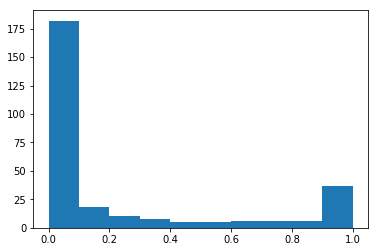

In [54]:
#This groups the predictions of the kois per star.


preds =xgbc.predict(koi) 
star_list_ids = np.unique(koi_SNR[:,0]) 
partially_detected = np.zeros_like(star_list_ids) #flag to see if at least one segment for that stasr was detected
detection_counts = np.zeros_like(star_list_ids)# raw count of segments per star that were detected
normalized_detection_counts = np.zeros_like(star_list_ids) # percentage of segments detected for each star id
not_detected = np.zeros_like(star_list_ids) # flag for stars not detected 1== not detected in any of its segments

print star_list_ids.shape
star_SNR =np.zeros_like(star_list_ids)
star_tol = np.zeros_like(star_list_ids)
star_transits = np.zeros_like(star_list_ids)
star_period = np.zeros_like(star_list_ids)

print "Unique starts" ,len(star_list_ids)

for i,id_num in enumerate(star_list_ids):
    indices = np.where(id_num == koi_SNR[:,0])[0]
    #print indices
    if  preds[indices].sum() >=1:
        partially_detected[i] = star_list_ids[i]
    else  :
        not_detected[i] = star_list_ids[i]
    detection_counts[i]=preds[indices].sum()
    normalized_detection_counts[i] = np.nansum(preds[indices].sum()/ len(np.where(preds[indices]!=np.nan)[0]))
    print np.nansum(preds[indices].sum()), len(np.where(preds[indices]!=np.nan)[0]) 
    star_SNR[i] = np.median(koi_SNR[indices,2])
    star_transits[i] = np.median(26//koi_periods[indices])
    star_tol[i] = np.median(koi_tol[indices,2])
    star_period[i] = np.median(koi_periods[indices])
    #The SNR of this star is incorrect, as it was uncorrectly detrended due to its short timescale variation(less than a day)
    #Thus the SNR for this star is manually set to zero
    if id_num==10736489:
        star_SNR[i]= 0

print "Stars detected", len(np.where(partially_detected!=0)[0])
plt.hist(normalized_detection_counts)
print "Stars Missed" , len(not_detected[np.where(not_detected!=0)[0]])

In [77]:
#print star_tol[np.where(star_list_ids ==2989404)[0]]#star_tol]
#preds =xgbc.predict(koi)
star_code = 2989404# 8644288#6850504 #5735762 #5735762 #8644288 # 2989404
indices = np.where(koi_SNR[:,0] == star_code)[0]
print indices
koi.loc[indices]
print "True", koi_true_trans[indices]
print "Signal",  koi_enough_sig[indices]
print "Transits", koi_enough_trans[indices]
print "Error", koi_low_tol[indices]
print "Periods", koi_periods[indices]
print xgbc.predict(koi.loc[indices])
feats = []
for feat in koi.columns.values:
    if "modshift" in feat:
        feats.append(feat)
print star_tol[np.where(star_list_ids == star_code)[0]]
print star_period[np.where(star_list_ids == star_code)[0]]
koi.loc[indices][feats]#[["modshiftval5_dv", "modshiftval2_dv"]]


[913 914 915 916 917 918 919 920 921 922 923 924]
True [1 1 1 1 1 1 1 1 1 1 1 1]
Signal [1 1 1 1 1 1 1 1 1 1 1 1]
Transits [1 1 1 1 1 1 1 1 1 1 1 1]
Error [1 1 1 1 1 1 1 1 1 1 1 1]
Periods [ 1.6783263   3.55383111  1.6783263   1.6783263   3.55383111  3.55383111
  1.6783263   1.6783263   1.6783263   3.55383111  3.55383111  1.6783263 ]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 0.00035847]
[ 1.6783263]


,modshiftval1_dv,modshiftval2_dv,modshiftval3_dv,modshiftval4_dv,modshiftval5_dv,modshiftval6_dv
913,-3.022729,-2.053038,-2.052916,-12.560942,-12.053037,-12.052916
914,-3.166764,-2.502583,-2.502471,-13.032353,-12.502678,-12.502565
915,-3.001035,-2.023299,-2.023070,-12.480917,-12.023400,-12.023171
916,-3.126163,-2.146039,-2.145922,-12.425372,-12.146103,-12.145986
917,-3.177860,-2.516081,-2.515957,-12.708286,-12.516178,-12.516053
918,-3.210971,-2.602739,-2.602241,-12.644393,-12.602532,-12.602035
919,-3.080528,-2.083763,-2.083597,-11.671057,-12.083792,-12.083626
920,-3.037079,-2.047563,-2.047418,-11.656530,-12.047615,-12.047470
921,-3.031850,-2.040445,-2.040287,-12.290995,-12.040459,-12.040302
922,-3.147688,-2.526636,-2.526500,-12.542039,-12.526701,-12.526565


Weak stars detected with low period err: 3 from 5
Weak stars detected with high period err: 13 from 135
Total Strong stars detected with low period err: 81 from 103
Strong stars detected with low period err with up to two transits: 4 from 15
Strong stars detected with low period err with 2 to 3 transits per segment: 5 from 16
Strong stars detected with low period err and tight transit cut: 72 from 72
[  1161345.   2692377.   2849805.   2989404.   3544595.   4149450.
   4180280.   4563268.   4644952.   4827723.   5084942.   5369827.
   5809890.   6020753.   6021275.   6029239.   6062088.   6063220.
   6289257.   6362874.   6752502.   7269493.   7273277.   7295235.
   7419318.   7447200.   7509886.   7626506.   7668663.   7967100.
   8142942.   8240797.   8277797.   8359498.   8454250.   8456679.
   8753657.   9139084.   9471268.   9527334.   9579641.   9597345.
   9655129.   9702072.   9704384.   9790806.   9881662.   9885417.
   9909735.   9963524.  10158418.  10190777.  10318874.  103

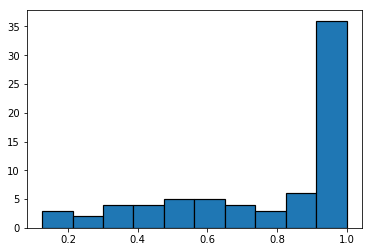

In [80]:
print "Weak stars detected with low period err:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR<SNR_cut))[0]), \
     "from", len(np.where( (star_tol<tolerance_cut) &(star_SNR<SNR_cut))[0])
print "Weak stars detected with high period err:", len(np.where( (partially_detected>0)& (star_tol>0.002) & (star_SNR<SNR_cut))[0]) ,\
 "from", len(np.where( (star_tol>tolerance_cut) &(star_SNR<SNR_cut))[0])


print "Total Strong stars detected with low period err:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut))[0]), \
 "from", len(np.where( (star_tol<tolerance_cut) &(star_SNR>SNR_cut) )[0])

    
print "Strong stars detected with low period err with up to two transits:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut) &(star_period>13))[0]), \
 "from", len(np.where( (star_tol<tolerance_cut) &(star_SNR>SNR_cut) &(star_period>13))[0])
    
    
print "Strong stars detected with low period err with 2 to 3 transits per segment:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut) & (star_period>8.67) & (star_period<13))[0]), \
 "from", len(np.where( (star_tol<tolerance_cut) &(star_SNR>SNR_cut) & (star_period>8.67) & (star_period<13))[0])
    
print "Strong stars detected with low period err and tight transit cut:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut)& (star_period<8.67))[0]), \
 "from", len(np.where( (star_tol<tolerance_cut) &(star_SNR>SNR_cut)  &(star_period<8.67) )[0])
    
print star_list_ids[np.where( (star_tol<tolerance_cut) &(star_SNR>SNR_cut)  &(star_period<8.67) )[0]]

print "Strong stars detected with high period err:", len  (np.where( (partially_detected>0)& (star_tol>0.002) &(star_SNR>6))[0]), \
 "from", len(np.where( (star_tol>tolerance_cut) &(star_SNR>SNR_cut))[0])
    
strong_star_detection_counts = normalized_detection_counts[np.where( (star_tol<0.002) &(star_SNR>SNR_cut)  &(star_period<8.67) )[0]]
#print strong_star_detection_counts 
plt.hist(strong_star_detection_counts,        edgecolor='black', linewidth=1.2)
print "Number of stars where all segments were detected", len(np.where(strong_star_detection_counts==1)[0])
print "Number of stars where half or more segments were detected", len(np.where(strong_star_detection_counts>=0.5)[0])
print "Total number of stars above SNR cut:", len(np.where(star_SNR > SNR_cut)[0])

Strong stars detected with low period err and tight transit cut: 72 from 72
108
Number of stars where all segments were detected 35
Number of stars where half or more segments were detected 59
Total number of stars above SNR cut: 143


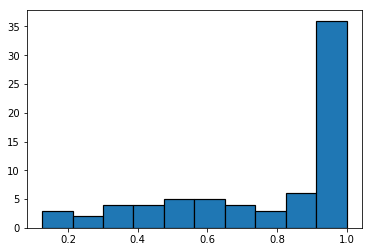

In [81]:
print "Strong stars detected with low period err and tight transit cut:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut)& (star_period<8.67))[0]), \
 "from", len(np.where( (star_tol<tolerance_cut) &(star_SNR>SNR_cut)  &(star_period<8.67) )[0])
print len(np.where(star_tol<tolerance_cut)[0])

plt.hist(strong_star_detection_counts,        edgecolor='black', linewidth=1.2)
print "Number of stars where all segments were detected", len(np.where(strong_star_detection_counts==1)[0])
print "Number of stars where half or more segments were detected", len(np.where(strong_star_detection_counts>=0.5)[0])
print "Total number of stars above SNR cut:", len(np.where(star_SNR > SNR_cut)[0])

(100,) (100,)
Detected: 75 from 77 at SNR 0.0
[ 8278371.  9221517.]
Detected: 75 from 77 at SNR 1.0101010101
[ 8278371.  9221517.]
Detected: 75 from 77 at SNR 2.0202020202
[ 8278371.  9221517.]
Detected: 75 from 77 at SNR 3.0303030303
[ 8278371.  9221517.]
Detected: 75 from 77 at SNR 4.0404040404
[ 8278371.  9221517.]
Detected: 75 from 77 at SNR 5.05050505051
[ 8278371.  9221517.]
Detected: 72 from 72 at SNR 6.06060606061
[]
Detected: 68 from 68 at SNR 7.07070707071
[]
Detected: 66 from 66 at SNR 8.08080808081
[]
Detected: 58 from 58 at SNR 9.09090909091
[]
Detected: 55 from 55 at SNR 10.101010101
[]
Detected: 51 from 51 at SNR 11.1111111111
[]
Detected: 47 from 47 at SNR 12.1212121212
[]
Detected: 44 from 44 at SNR 13.1313131313
[]
Detected: 39 from 39 at SNR 14.1414141414
[]
Detected: 35 from 35 at SNR 15.1515151515
[]
Detected: 33 from 33 at SNR 16.1616161616
[]
Detected: 32 from 32 at SNR 17.1717171717
[]
Detected: 30 from 30 at SNR 18.1818181818
[]
Detected: 27 from 27 at SNR 19.1

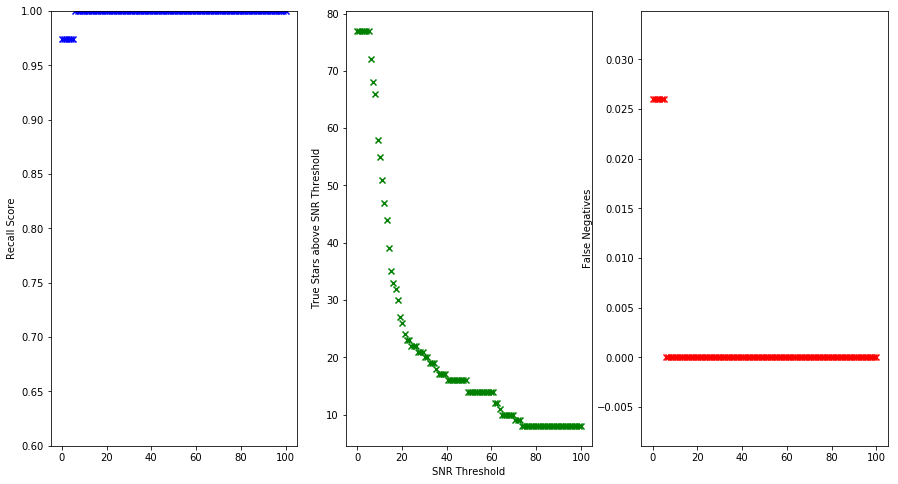

In [58]:
x = np.linspace(0,100,100)#data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAW4AAAD8CAYAAABXe05zAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAADMlJREFUeJzt3WuMXHUZx/Hfr7MYdazL0oI16NA2qBGJqDtigsbgNYBGQyTxbhMxG000NtGovJGor3xj+sbbBo1NvEWiNQYBgxdsjIK2iFguGixUIU4odh3gYAq7fXyxg6zNbue0nXMOz8z3k2zYpYf5P/+d9tuTM2cWR4QAAHmsa3oAAMDxIdwAkAzhBoBkCDcAJEO4ASAZwg0AyRBuAEiGcANAMoQbAJKZquJBN27cGJs3b67ioQFgLO3du/fBiDi9zLGVhHvz5s3as2dPFQ8NAGPJ9oGyx3KpBACSIdwAkAzhBoBkCDcAJEO4ASCZUneV2L5X0sOSliQtRkS3yqEAAGs7ntsBXxcRD1Y2CQCgFC6VAEAyZc+4Q9LPbS9J+npEzFc408Tp9/sqiqL2ddvttqanp2tft0l8rzEOyob7NRFxv+0zJN1g+66I2L3yANtzkuYkqdPpjHjM8dXv93XWlq3qLxyqfe3pmdN04J79ExMUvtcYF6XCHRH3D/75gO1dks6XtPuoY+YlzUtSt9vlfx1fUlEU6i8c0qZtO9Rqz9S27lKxoN7O7SqKYmJiwvca42JouG23Ja2LiIcHn79Z0ucrn2zCtNozmlq/oekxJgLfa2RX5oz7OZJ22X7i+O9GxPWVTgUAWNPQcEfEfknn1TALAKAEbgcEgGQINwAkQ7gBIBnCDQDJEG4ASIZwA0AyhBsAkiHcAJAM4QaAZAg3ACRDuAEgGcINAMkQbgBIhnADQDKEGwCSIdwAkAzhBoBkCDcAJEO4ASAZwg0AyRBuAEiGcANAMoQbAJIh3ACQDOEGgGQINwAkQ7gBIBnCDQDJEG4ASIZwA0AyhBsAkiHcAJBM6XDbbtn+o+1rqhwIAHBsx3PG/XFJd1Y1CACgnFLhtv08SW+RdFW14wAAhpkqedwOSZ+StL7CWTBB+v2+iqKodc1er1frekBVhobb9lslPRARe21feIzj5iTNSVKn0xnZgBg//X5fZ23Zqv7CoaZHAVIqc8b9aklvs32JpKdLerbtb0fE+1YeFBHzkuYlqdvtxsgnxdgoikL9hUPatG2HWu2Z2tZ97OC9Onj1lbWtB1RlaLgj4gpJV0jS4Iz7k0dHGzgRrfaMptZvqG29pWKhtrWAKnEfNwAkU/bFSUlSRNwo6cZKJgEAlMIZNwAkQ7gBIBnCDQDJEG4ASIZwA0AyhBsAkiHcAJAM4QaAZAg3ACRDuAEgGcINAMkQbgBIhnADQDKEGwCSIdwAkAzhBoBkCDcAJEO4ASAZwg0AyRBuAEiGcANAMoQbAJIh3ACQDOEGgGQINwAkQ7gBIBnCDQDJEG4ASIZwA0AyhBsAkiHcAJAM4QaAZAg3ACQzNNy2n27797b/ZPt225+rYzAAwOqmShxzWNLrI+IR26dI+o3t6yLipopnAwCsYmi4IyIkPTL48pTBR1Q5FABgbWXOuGW7JWmvpLMlfTkibq5qoH6/r6Ioqnr4NbXbbU1PT9e+btN6vd5ErAmMk1LhjoglSS+zfaqkXbbPjYh9K4+xPSdpTpI6nc4JDdPv93XWlq3qLxw6of/+ZEzPnKYD9+yfmHgfOfyotK6l2dnZpkcBcJxKhfsJEfFv27+SdJGkfUf92rykeUnqdrsndCmlKAr1Fw5p07YdarVnTuQhTshSsaDezu0qimJiwh2Lh6UjS7V/ryXpsYP36uDVV9a6JjBOhobb9umSHh9E+xmS3iTpi1UO1WrPaGr9hiqXwEAT3+ulYqHW9YBxU+aM+7mSdg6uc6+T9IOIuKbasQAAaylzV8ltkl5ewywAgBJ45yQAJEO4ASAZwg0AyRBuAEiGcANAMoQbAJIh3ACQDOEGgGQINwAkQ7gBIBnCDQDJEG4ASIZwA0AyhBsAkiHcAJAM4QaAZAg3ACRDuAEgGcINAMkQbgBIhnADQDKEGwCSIdwAkAzhBoBkCDcAJEO4ASAZwg0AyRBuAEiGcANAMoQbAJIh3ACQDOEGgGSGhtv2823/yvYdtm+3/fE6BgMArG6qxDGLkj4REbfYXi9pr+0bIuKOimcDAKxi6Bl3RPwzIm4ZfP6wpDslnVn1YACA1ZU54/4f25slvVzSzVUMA4yzXq/XyLrtdlvT09ONrI1qlA637WdJ+qGk7RHx0Cq/PidpTpI6nc7IBgSyO3L4UWldS7Ozs42sPz1zmg7cs594j5FS4bZ9ipaj/Z2I+NFqx0TEvKR5Sep2uzGyCYHkYvGwdGRJm7btUKs9U+vaS8WCeju3qygKwj1GhobbtiV9Q9KdEfGl6kcCxlOrPaOp9RuaHgNjoMx93K+W9H5Jr7d96+DjkornAgCsYegZd0T8RpJrmAUAUALvnASAZAg3ACRDuAEgGcINAMkQbgBIhnADQDKEGwCSIdwAkAzhBoBkCDcAJEO4ASAZwg0AyRBuAEiGcANAMoQbAJIh3ACQDOEGgGQINwAkQ7gBIBnCDQDJEG4ASIZwA0AyhBsAkiHcAJAM4QaAZAg3ACRDuAEgGcINAMkQbgBIhnADQDKEGwCSIdwAkAzhBoBkhobb9jdtP2B7Xx0DAQCOrcwZ97ckXVTxHACAkqaGHRARu21vrn4UAFXp9Xq1r7m4uKipqaGJGau12+22pqenK19nZDuzPSdpTpI6nc6oHhbASThy+FFpXUuzs7O1r+3WlGJpsfZ1m1x7euY0Hbhnf+XxHlm4I2Je0rwkdbvdGNXjAjhxsXhYOrKkTdt2qNWeqW3dxw7eq4NXX1n7uk2uvVQsqLdzu4qiyBNuAE9drfaMptZvqG29pWKhkXWbXrsu3A4IAMmUuR3we5J+J+lFtu+zfXn1YwEA1lLmrpJ31zEIAKAcLpUAQDKEGwCSIdwAkAzhBoBkCDcAJEO4ASAZwg0AyRBuAEiGcANAMoQbAJIh3ACQDOEGgGQINwAkQ7gBIBnCDQDJEG4ASIZwA0AyhBsAkiHcAJAM4QaAZAg3ACRDuAEgGcINAMkQbgBIhnADQDKEGwCSIdwAkAzhBoBkCDcAJEO4ASAZwg0AyRBuAEimVLhtX2T7L7bvtv2ZqocCAKxtaLhttyR9WdLFks6R9G7b51Q9GABgdWXOuM+XdHdE7I+IxyR9X9Lbqx0LALCWqRLHnCnpHyu+vk/Sq6oZZ9lSsVDlw6+5Xq/Xq3XdlWvWvudH+42s2+Tak7Zuk2tP5J5rXM8RcewD7MskXRQRHxp8/X5Jr4qIjx513JykucGXL5L0l9GPW5uNkh5seogasM/xwj5zOysiTi9zYJkz7vslPX/F188b/Lv/ExHzkuZLjfcUZ3tPRHSbnqNq7HO8sM/JUeYa9x8kvcD2FttPk/QuST+pdiwAwFqGnnFHxKLtj0r6maSWpG9GxO2VTwYAWFWZSyWKiGslXVvxLE8lY3HJpwT2OV7Y54QY+uIkAOCphbe8A0AyEx3uYW/lt/1e27fZ/rPt39o+r4k5T1aJfb59sM9bbe+x/Zom5jxZZX80g+1X2l4c3OqaTonn80Lb/cHzeavtzzYx58kq83wO9nqr7dtt/7ruGRsTERP5oeUXWv8maaukp0n6k6RzjjrmAkkzg88vlnRz03NXtM9n6cnLZi+VdFfTc1exzxXH/VLLr9lc1vTcFT2fF0q6pulZa9jnqZLukNQZfH1G03PX9THJZ9xD38ofEb+NiCfeDnWTlu9hz6bMPh+Jwe98SW1JGV/4KPujGT4m6YeSHqhzuBGalB9BUWaf75H0o4j4uyRFRNbn9LhNcrhXeyv/mcc4/nJJ11U6UTVK7dP2pbbvkvRTSR+sabZRGrpP22dKulTSV2uca9TK/r69YHD56zrbL6lntJEqs88XSpqxfaPtvbY/UNt0DSt1O+Cks/06LYc75bXfMiJil6Rdtl8r6QuS3tjwSFXYIenTEXHEdtOzVOkWLV8+eMT2JZJ+LOkFDc9UhSlJs5LeIOkZkn5n+6aI+GuzY1VvksNd6q38tl8q6SpJF0fEv2qabZRK7fMJEbHb9lbbGyMi08+DKLPPrqTvD6K9UdIlthcj4sf1jDgSQ/cZEQ+t+Pxa218Z0+fzPkn/iohCUmF7t6TzJI19uBu/yN7Uh5b/0tovaYuefPHjJUcd05F0t6QLmp634n2erSdfnHyFlv+AuOnZR73Po47/lnK+OFnm+dy04vk8X9Lfx/H5lPRiSb8YHPtMSfskndv07HV8TOwZd6zxVn7bHx78+tckfVbSBklfGZylLUayH25Tcp/vkPQB249L+o+kd8bgT0YWJfeZXsl9XibpI7YXtfx8vmscn8+IuNP29ZJuk3RE0lURsa+5qevDOycBIJlJvqsEAFIi3ACQDOEGgGQINwAkQ7gBIBnCDQDJEG4ASIZwA0Ay/wUMjQ+E8hGMTwAAAABJRU5ErkJggg==
y = np.zeros(x.shape[0])
y_total_count = np.zeros_like(y)
y_missed = np.zeros_like(y)
print x.shape, y.shape
for i, val in enumerate(x):
    SNR_cut_val = val
    y[i] = len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut_val)& (star_period<8.67))[0]) / float(len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut_val)  &(star_period<8.67) )[0]))
    print "Detected:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut_val)& (star_period<8.67))[0]),  "from",  (len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut_val)  &(star_period<8.67) )[0])), "at SNR", val
    print star_list_ids[np.where( (not_detected!=0)& (star_tol<0.002) &(star_SNR>SNR_cut_val)& (star_period<8.67))[0]]
    y_total_count[i] = len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut_val)  &(star_period<8.67) )[0])
    y_missed[i] = len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut_val)  &(star_period<8.67) & (not_detected!=0) )[0]) /float(len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut_val)  &(star_period<8.67)  )[0]))
fig = plt.figure(figsize=((15,8)))
ax = fig.add_subplot("131")
ax.set_ylabel("Recall Score")
ax.scatter(x, y, marker = "x", color = "blue")

ax2= fig.add_subplot("132")
ax2.scatter(x, y_total_count, marker = "x", color = "green")
ax2.set_ylabel("True Stars above SNR Threshold")

ax3= fig.add_subplot("133")
ax3.scatter(x, y_missed, marker = "x", color = "red")
ax3.set_ylabel("False Negatives")
ax.set_ylim([0.6,1])
ax2.set_xlabel("SNR Threshold")

In [85]:
#create SNR hoist of total 283 stars minus the 72 signals passing strict period cut and period error cut. 
strong_stars_low_err = star_SNR[np.where( (star_tol<tolerance_cut)   &(star_period<(26./ped_constraint)) )[0]]
weak_err_Stars = star_SNR[np.where( (star_tol> tolerance_cut) + (star_period>(26./ped_constraint)) )[0] ]
weak_star_detections = normalized_detection_counts[np.where( (star_tol> tolerance_cut) + (star_period>(26./ped_constraint)) )[0]]

print len(weak_err_Stars), len(strong_stars_low_err), len(weak_star_detections)
print SNR_cut
week_err_Stars_ids_high_SNR = star_list_ids[np.where( ((star_tol> tolerance_cut) + (star_period>(26./ped_constraint))) * (star_SNR>SNR_cut) )[0]]

print len(week_err_Stars_ids_high_SNR) , week_err_Stars_ids_high_SNR
print weak_err_Stars
'''
plt.figure(figsize = (14, 8))
plt.hist(weak_err_Stars, edgecolor='black', linewidth=1.2, bins = np.linspace(1, 100, 25))
plt.ylabel("Frequency")
plt.xlabel("SNR")
plt.ylim([0,25])
plt.figure()
plt.hist(weak_star_detections)
'''

206 77 206
6
71 [  2302548.   2304320.   2438513.   2441495.   2444412.   2571238.
   2853446.   3102384.   3446746.   3541946.   3733628.   4164922.
   4278221.   4349442.   4644604.   4857213.   5020319.   5185897.
   5375194.   5383248.   5695396.   5735762.   5796675.   5941160.
   6541920.   6678383.   6779260.   6850504.   6851425.   7115785.
   7202957.   7887791.   7976520.   8008067.   8107380.   8395660.
   8552719.   8628758.   8644288.   8644365.   8692861.   8711794.
   8738735.   8750043.   8766650.   8802165.   9002278.   9266431.
   9455325.   9527915.   9573539.   9597058.   9950612.  10024701.
  10130039.  10154388.  10187017.  10545066.  10676014.  10925104.
  10984090.  11100383.  11241912.  11394027.  11395587.  11402995.
  11554435.  11568987.  11954842.  12068975.  12785320.]
[  2.91269386   3.11329098   3.34661078  13.81207963   6.10248907
   7.04272093  13.79934718  19.79719365  35.41973428   1.92979978
  10.90155625   2.12004603   3.96413523  17.45370777   2.7

'\nplt.figure(figsize = (14, 8))\nplt.hist(weak_err_Stars, edgecolor=\'black\', linewidth=1.2, bins = np.linspace(1, 100, 25))\nplt.ylabel("Frequency")\nplt.xlabel("SNR")\nplt.ylim([0,25])\nplt.figure()\nplt.hist(weak_star_detections)\n'

In [84]:
#'''
#create pd frame of all segments of stars dIIetected and stars missed
missed_strong_star_feats = np.empty(shape = (0,29))

for star_ID in missed_strong_stars:
    indices = np.where(star_ID==koi_SNR[:,0])
    print koi.loc[indices].shape
    print missed_strong_star_feats
    missed_strong_star_feats = np.append(missed_strong_star_feats, koi.loc[indices], axis = 0)
    
    print missed_strong_stars
    #break
#koi.head()
print missed_strong_star_feats.shape

#do quick tuning, is the model just using poor parameters if its missing half of the strong signals?
#print star_SNR[np.where(star_list_ids== 2853446)[0]]
#print preds[np.where(koi_SNR[:,0] == 2853446)[0]]

#create pd frame of all segments of stars dIIetected and stars missed
detected_strong_star_feats = np.empty(shape = (0,29))

for star_ID in detected_strong_stars:
    indices = np.where(star_ID==koi_SNR[:,0])
    #print koi.loc[indices].shape
    detected_strong_star_feats = np.append(detected_strong_star_feats, koi.loc[indices], axis = 0)
        #print missed_strong_stars
    #break
#koi.head()
print detected_strong_star_feats.shape

#print missed_strong_stars_segments
#koi_SNR[0,:] in missed_strong_stars

#'''

NameError: name 'missed_strong_stars' is not defined

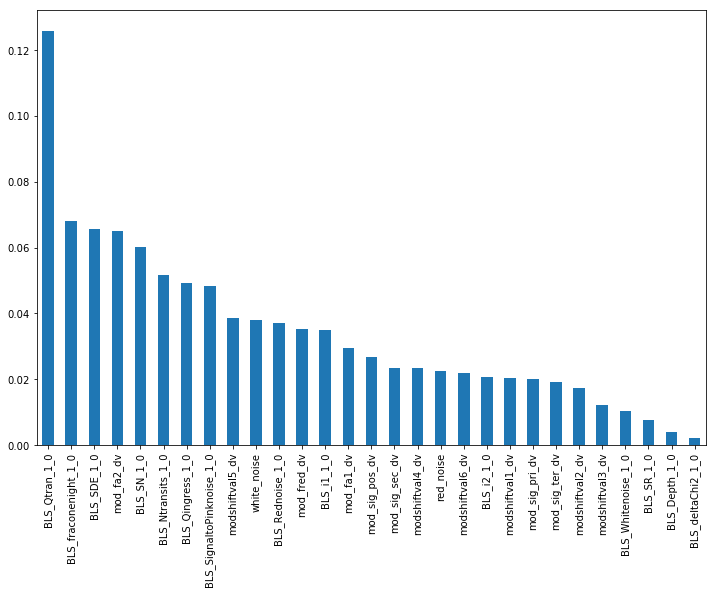

In [61]:
feat_imp = pd.Series(xgbc.booster().get_fscore()  ).sort_values(ascending =False)
feat_sum = feat_imp.values.sum()
feat_imp = feat_imp/feat_sum
feat_imp.plot(kind = "bar", figsize=((12, 8)))

In [62]:
#find cross validated score with a stratified split
skfX = StratifiedKFold(n_splits=5 , random_state=0)
total_predictions = np.zeros_like(shuffleY)
total_Y = np.zeros_like(shuffleY)
total_labels = np.zeros_like(shuffleY)
total_data = np.zeros_like(shuffleX)
score = 0.

for train_index, test_index in skfX.split(shuffleX, shuffle_labels):
    x_train, x_test = shuffleX.loc[train_index], shuffleX.loc[test_index]
    y_train, y_test = shuffleY[train_index], shuffleY[test_index]
    label_train, label_test = shuffle_labels[train_index], shuffle_labels[test_index]
    xgbc.fit(x_train, y_train)
    preds_Y=xgbc.predict(x_test)
    total_predictions = np.r_[total_predictions, preds_Y]
    total_Y = np.r_[total_Y, y_test]
    total_data = np.r_[total_data, x_test]
    total_labels = np.r_[total_labels, label_test]
    print metrics.average_precision_score(y_test, preds_Y)
    score = score + metrics.average_precision_score(y_test, preds_Y)
    print score/ 5.
print "Strong Injections detected", len(np.where((total_predictions==1)&(total_labels==1)&(total_Y==1))[0]),"from", len(np.where((total_labels==1)&(total_Y==1))[0])
print "Weak Injections detected with period cut", len(np.where((total_predictions==1)&(total_labels==1)&(total_Y==0))[0]),"from", len(np.where((total_labels==1)&(total_Y==0))[0])
print "Inverted Rejected", len(np.where((total_predictions==0)&(total_labels==2)&(total_Y==0))[0]),"from", len(np.where((total_labels==2)&(total_Y==0))[0])
print "NON_KOI_Rejected", len(np.where((total_predictions==0)&(total_labels==4)&(total_Y==0))[0]),"from", len(np.where((total_labels==4)&(total_Y==0))[0])


0.982384936023
0.196476987205
0.984475506193
0.393372088443
0.984400281167
0.590252144677
0.982372158207
0.786726576318
0.981183177055
0.982963211729
Strong Injections detected 6149 from 6215
Weak Injections detected with period cut 150 from 3785
Inverted Rejected 14998 from 15000
NON_KOI_Rejected 988 from 1000
